# Boids

To get started with agent-based modelling, we'll recreate the classic
[Boids](https://en.wikipedia.org/wiki/Boids) simulation of flocking
behavior. This is a relatively simple example but it produces
very pleasing visualizations.

### 0. Some Terminology

There's a lot going on in `vivarium`, and so it's useful to define
a few terms up front:

- **simulant**: An individual or agent. One member of the population
  being simulated.
- **attribute**: A variable associated with each simulant. For example,
  each simulant may have an attribute to describe their age or position.
- **component**: Any self-contained piece of code that can be plugged
  into the simulation to add some functionality. In `vivarium`
  we typically think of components as encapsulating and managing
  some behavior or attributes of the simulants.

### 1. Building a population


In many ways, this is a bad place to start. The population component
is one of the more complicated components in the simulation as it
typically is responsible for bootstrapping some of the more interesting
features in `vivarium`.  What we'll do is start with a simple population
and revisit this component as we wish to add more complexity.

```python
import numpy as np
import pandas as pd

class Population:
    configuration_defaults = {
        'population': {
            'colors': ['red', 'blue']
        }
    }

    def setup(self, builder):
        self.colors = builder.configuration.population.colors

        columns_created = ['color', 'entrance_time']
        builder.population.initializes_simulants(self.on_initialize_simulants, columns_created)
        self.population_view = builder.population.get_view(columns_created)

    def on_initialize_simulants(self, pop_data):
        new_population = pd.DataFrame({
            'color': np.random.choice(self.colors, len(pop_data.index)),
            'entrance_time': pop_data.creation_time,
        }, index= pop_data.index)
        self.population_view.update(new_population)
```

Here we're defining a component that generates a population of 1000 birds. Those birds
are then randomly chosen to be either red or blue.

Let's examine what's going on in detail, as you'll see many of the same patterns
repeated in later components.

#### Imports

```python
import numpy as np
import pandas as pd
```

`numpy` is a library for doing high performance numerical computing in python.
`pandas` is a set of tools built on top of numpy that allow for fast database
style querying and aggregating of data. `vivarium` uses `pandas.DataFrame` objects
as it's underlying representation of the population and for many other data storage
and manipulation tasks. By convention, most people abbreviate these packages as `np`
and `pd` respectively, and we'll follow that convention here.

#### Population class

`vivarium` components are expressed as [Python classes](https://docs.python.org/3.6/tutorial/classes.html).
You can find many resources on classes and object-oriented programming with a simple google search.
We'll assume some fluency with this style of programming, but you should be able to follow along
with most bits even if you're unfamiliar.

#### Configuration Defaults

In most simulations, we want to have an easily tunable set up knobs to adjust various parameters.
`vivarium` accomplishes this by pulling those knobs out as configuration information. Components
typically expose the values they use int he `configuration_defaults` class attribute.
We'll talk more about configuration information later. For now observe that we're exposing the size
of the population that we want to generate and a set of possible colors for our birds.

#### setup

**# TODO: Link to builder documentation**

Almost every component in `vivarium` will have a setup method. The setup method
gives the component access to a `builder` object that exposes a handful
of tools to help build components. The simulation framework is resoponsible for calling
the `setup` method on components and providing the builder to them.
We'll explore these tools that the builder provides in detail as we go.

```python
    def setup(self, builder):
        self.colors = builder.configuration.population.colors

        columns_created = ['color', 'entrance_time']
        builder.population.initializes_simulants(self.on_initialize_simulants, columns_created)
        self.population_view = builder.population.get_view(columns_created)
```

Our setup method is doing three things.

First, it's accessing the subsection of the configuration that it cares about.
The full simulation configuration is available from the builder as
`builder.configuration`. You can treat the configuration object just like
a nested python dictionary that's been extended to support dot-style attribute access.
Our access here mirrors what's in the `configuration_defaults` at the top
of the class definition.

Next, we interact with the `vivarium`'s population management system.  We
create a variable to hold the names of the columns we want to create.

<div class="alert alert-info">

**The Population Table**

   When we talk about columns in the context of `vivarium`, we are typically
   talking about the **attributes** we defined at the top of this tutorial.

   `vivarium` represents the population of simulants as a single `pandas.DataFrame`.
   We think of each simulant as a row in this table and each column as an attribute
   of the simulants.
   
</div>

**# TODO: Link to population manager interface documentation**

We then make a call to the population tool on the `builder` with

```python
builder.population.initializes_simulants(self.on_initialize_simulants, columns_created)
```

This tells the simulation that any time new people get added to the simulation from
any component the framework should call the `on_initialize_simulants` function in this
component to set the `'entrance_time'` and `'color'` columns for each new simulant.

We'll see a third argument for this function soon and discuss the population management
system in more detail.

Next, we get a view into the population table with

```python
self.population_view = builder.population.get_view(columns_created)
```

Population views are used both to query the current state of simulants and to update
that state information.  When you request a population view from the `builder`, you
must tell it which columns in the population table you want to see, and so here we pass
along the same set of columns we've said we're creating.

#### on_initialize_simulants

Finally we look at the `on_initialize_simulants` method.  You can name this whatever
you like in practice, but I have a tendency to give methods that the framework is calling
names that describe where in the simulation life-cycle they occur. This helps me
think more clearly about what's going on and helps debugging.

If we look at the method signature:

```python
def on_initialize_simulants(self, pop_data):
```
we see that like the `setup` method, `on_initialize_simulants` takes in a special
argument that we don't provide.  This argument `pop_data` is an object containing
a handful of information useful when initializing simulants.

**#TODO: Link to the SimulantData documentation**

The only two we need for now are the ``pop_data.index``, which supplies the ``pandas`` index
of the simulants to be initialized, and the ``pop_data.creation_time`` which gives us
a representation (typically an ``int`` or ``pandas.Timestamp``) of the simulation time
when the simulant was generated.


<div class="alert alert-info">

**The Population Index**

The population table we described before has an index that uniquely identifies
each simulant. This index is used in several places in the simulation to look
up information, calculate simulant-specific values, and update information
about the simulants' state.
   
</div>

Using the population index, we generate a `pandas.DataFrame` and fill it with the initial values
of `'entrance_time'` and `'color'` for each new simulant

```python
new_population = pd.DataFrame({
    'color': np.random.choice(self.colors, len(pop_data.index)),
    'entrance_time': pop_data.creation_time,
}, index= pop_data.index)
```

Right now, this is just a table with data hanging out in our simulation.  To actually
do something, we have to tell the population management system to update

```python
self.population_view.update(new_population)
```

Putting this all back together:

In [12]:
import numpy as np
import pandas as pd

class Population:
    configuration_defaults = {
        'population': {
            'population_size': 100,
            'colors': ['red', 'blue']
        }
    }

    def setup(self, builder):
        self.colors = builder.configuration.population.colors
        columns_created = ['color', 'entrance_time']
        builder.population.initializes_simulants(self.on_create_simulants, columns_created)
        self.population_view = builder.population.get_view(columns_created)

    def on_create_simulants(self, pop_data):
        new_population = pd.DataFrame({
            'color': np.random.choice(self.colors, len(pop_data.index)),
            'entrance_time': pop_data.creation_time,
        }, index= pop_data.index)
        self.population_view.update(new_population)


`vivarium` supports both a command line interface and an interactive one. We'll look at how to run simulations from the command line later. For now, we can setup a simulation with the following code:

In [13]:
from vivarium.interface import setup_simulation

sim = setup_simulation([Population()])

# Then peek at the population table
sim.population.population.head(10)

,tracked,color,entrance_time
0,True,blue,2005-07-01
1,True,blue,2005-07-01
2,True,blue,2005-07-01
3,True,blue,2005-07-01
4,True,blue,2005-07-01
5,True,blue,2005-07-01
6,True,blue,2005-07-01
7,True,red,2005-07-01
8,True,blue,2005-07-01
9,True,red,2005-07-01


#### Now what?

At this point, you should be able to figure out how to add new attributes to your simulants by modifying the `on_initialize_simulants` method in our `Population` component. This is a pretty boring simulation though. Let's add some behavior. 

### 2.  Adding position into the model

The classic Boids model introduces three _steering_ behaviors into a population of birds and simulates their resulting behavior. For this to work, we need to track the position and velocity of our birds, so let's start there.



In [14]:
class Location:
    configuration_defaults = {
        'location': {
            'width': 1000,   # Width of our field
            'height': 1000,  # Height of our field            
        }
    }

    def setup(self, builder):
        self.width = builder.configuration.location.width
        self.height = builder.configuration.location.height
        
        columns_created = ['x', 'vx', 'y', 'vy']
        builder.population.initializes_simulants(self.on_create_simulants, columns_created)
        self.population_view = builder.population.get_view(columns_created)

    def on_create_simulants(self, pop_data):
        count = len(pop_data.index)        
        # Start clustered in the center with small random velocities        
        new_population = pd.DataFrame({
            'x': self.width * (0.4 + 0.2 * np.random.random(count)),
            'y': self.height * (0.4 + 0.2 * np.random.random(count)),
            'vx': -0.5 + np.random.random(count),
            'vy': -0.5 + np.random.random(count),
        }, index= pop_data.index)
        self.population_view.update(new_population)


You'll notice that this looks very similar to our initial population model.  Indeed, we can split up the responsibilities of initializing simulants over many different components.  In `vivarium` we tend to think of components as being responsible for individual behaviors or attributes. This makes it very easy to build very complex models while only having to think about local pieces of it.

Let's look again at the population table:

In [15]:
sim = setup_simulation([Population(), Location()])

sim.population.population.head(10)

,tracked,vy,vx,x,y,color,entrance_time
0,True,0.215589,0.393752,462.421484,559.798638,blue,2005-07-01
1,True,-0.400914,-0.396285,426.176134,555.341979,red,2005-07-01
2,True,-0.067209,-0.363805,505.078136,427.748882,blue,2005-07-01
3,True,0.229132,0.263169,403.262758,517.113090,blue,2005-07-01
4,True,0.376523,0.195722,509.884657,400.090015,red,2005-07-01
5,True,0.170249,0.327851,464.427290,558.106497,red,2005-07-01
6,True,0.094017,0.153177,556.473422,468.538927,blue,2005-07-01
7,True,-0.421570,-0.183405,595.451929,412.907204,red,2005-07-01
8,True,0.405473,-0.305188,599.510008,466.816706,red,2005-07-01
9,True,0.438924,0.192920,546.754276,529.230076,red,2005-07-01


#### 2.5 Visualizing our population

Now is also a good time to come up with a way to plot our birds. We'll later use this to generate animations of our birds flying around. We'll use `matplotlib` for this.  Making good visualizations is hard, and beyond the scope of this tutorial, but the (`matplotlib` documentation)[https://matplotlib.org/gallery/index.html] has a large number of examples of how to make different kinds of plots.

For our purposes, we really just want to be able to plot the posistions of our birds and maybe some arrows to indicated their velocity.

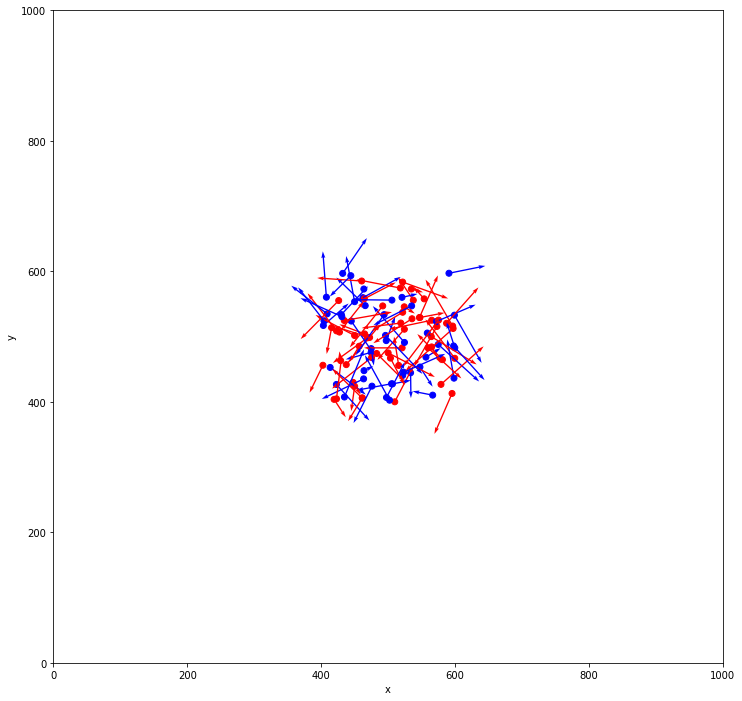

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_birds(simulation, plot_velocity=False):
    width = simulation.configuration.location.width
    height = simulation.configuration.location.height
    pop = simulation.population.population
    
    plt.figure(figsize=[12, 12])
    plt.scatter(pop.x, pop.y, color=pop.color)
    if plot_velocity:
        plt.quiver(pop.x, pop.y, pop.vx, pop.vy, color=pop.color, width=0.002)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis([0, width, 0, height])
    plt.show()
    
plot_birds(sim, True)

#### 3. Calculating Neighbors

The steering behavior in the Boids model is dictated by interactions of each bird with its nearby neighbors. A naive implementation of this can be very expensive. Luckily, python has a ton of great libraries that have solved most of the hard problems. Here, we'll pull in a (KDTree)(https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.spatial.KDTree.query.html 

In [ ]:
class Neighbors:
    configuration_defaults = {
        'neighbors': {
            'radius' = 10
        }
    }
    
    def setup(self, builder):
        self.radius = builder.configuration.neighbors
        
        self.neighbors_calculated = pd.Series()
        self._neighbors = None        
        self.neighbors = builder.value.register_value_producer('neighbors', source=self.get_neighbors)
        
        builder.population.initializes_simulants(self.on_create_simulants)
        self.population_view = builder.population.get_view(['x', 'y'])
        
        builder.event.register_listener('time_step', self.on_time_step)
        
    def on_create_simulants(self, pop_data):
        self.neigbhors_calculated.append(pd.Series(False, index=pop_data.index))
        
    def on_time_step(self, event):
        self.neighbors_calculated.iloc[:] = False
        
    def get_neighbors(self, index):
        if not self.neighbors_calculated:
            self.calculate_neighbors(index)
        return self.neighbors(index)
    
    def calculate_neighbors(index):
        pop = self.population_view.get(index)
        tree = spatial.KDTree(pop[['x', 'y']])
        
        
        
    
        
        
        


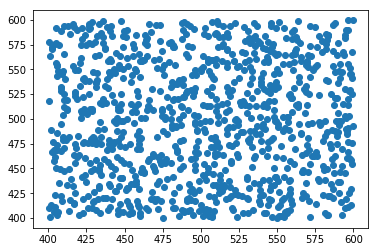

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

pop = sim.population.population

plt.plot(pop.x, pop.y, 'o')


In [5]:
import numpy as np
import pandas as pd
from scipy import spatial

points = pd.DataFrame({'x': np.random.random(100), 'y': np.random.random(100)}, index=range(10, 110))
tree = spatial.KDTree(points)

/home/james/miniconda3/envs/vivarium/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/james/miniconda3/envs/vivarium/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
tree.query_ball_tree(tree, 0.1)

[[0, 43, 47, 61],
 [1, 51, 94],
 [2, 8],
 [3, 9, 14, 48, 80, 57],
 [98, 60, 4, 17],
 [5, 63, 45],
 [36, 6],
 [7, 11],
 [81, 2, 8, 44, 50, 58],
 [3, 9, 14, 48, 74, 80],
 [10, 68, 22],
 [7, 11, 19],
 [89, 12, 26, 30, 32, 76, 92, 95],
 [13, 54, 55, 86],
 [3, 9, 14, 48, 74, 80, 97],
 [15, 41, 85],
 [16, 90],
 [98, 60, 4, 17],
 [18, 35, 78],
 [11, 19],
 [20, 72, 74, 99],
 [21],
 [10, 22],
 [69, 23],
 [93, 24, 42, 67, 83, 82, 99],
 [25, 84],
 [12, 26, 30, 76, 92],
 [27, 40, 59, 75],
 [28, 33],
 [64, 29, 33],
 [89, 12, 26, 30, 32, 76, 92],
 [77, 89, 97, 31, 32, 46, 95],
 [89, 12, 30, 31, 32, 46, 92, 95],
 [28, 29, 33],
 [42, 67, 34, 51, 82],
 [18, 35],
 [36, 86, 6],
 [37, 87],
 [38, 79, 88],
 [39],
 [27, 40, 59, 93, 83],
 [15, 41, 45, 53, 85],
 [24, 42, 67, 34, 51, 82],
 [0, 43, 47, 61],
 [81, 8, 44, 58],
 [5, 63, 41, 45, 53],
 [31, 32, 46, 95],
 [0, 43, 47],
 [3, 9, 14, 48, 74, 80],
 [54, 49, 56],
 [8, 50],
 [42, 1, 34, 51, 82],
 [52, 66],
 [41, 45, 53, 65],
 [13, 54, 55, 75, 49],
 [13, 54, 